In [1]:
# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
import cv2
import numpy as np
import json
import shutil
import os
import glob
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv


In [3]:
class setup:
    algo = 'MOG2'

In [2]:
basepath = '../data/islands/images/images/' # refactor to match path naming
metadata_path = '../data/islands/metadata.json'
seq_path = '../data/testseq/'
with open(metadata_path) as f:
    d = json.load(f)

In [69]:
[i for i in d['annotations'] if i.get('category_id') == 4]

[{'id': '16ed7302-4a53-11eb-9d03-000d3a74c7de',
  'image_id': '4c0cdea2-b3aa-482a-906f-f5af785940b1',
  'category_id': 4,
  'sequence_level_annotation': False,
  'bbox': [201, 570, 134, 175]},
 {'id': '16fe8a0b-4a53-11eb-b492-000d3a74c7de',
  'image_id': '4914cf13-070d-4f87-a83f-422afd7d094c',
  'category_id': 4,
  'sequence_level_annotation': False,
  'bbox': [50, 636, 236, 123]},
 {'id': '17014944-4a53-11eb-bbbd-000d3a74c7de',
  'image_id': 'a2741307-5fac-431d-9255-fa305f031dcf',
  'category_id': 4,
  'sequence_level_annotation': False,
  'bbox': [532, 910, 252, 136]},
 {'id': '17014945-4a53-11eb-90ee-000d3a74c7de',
  'image_id': '92b5599e-ca05-47a3-8648-88f98b5d6be4',
  'category_id': 4,
  'sequence_level_annotation': False,
  'bbox': [428, 946, 285, 100]},
 {'id': '17014946-4a53-11eb-b5bf-000d3a74c7de',
  'image_id': '0f194ac6-9144-49a0-b5dd-f8c7624f2913',
  'category_id': 4,
  'sequence_level_annotation': False,
  'bbox': [706, 873, 201, 109]},
 {'id': '17036c02-4a53-11eb-9d49-000

In [73]:
[i for i in d['images'] if i.get('id')=='92b5599e-ca05-47a3-8648-88f98b5d6be4']

[{'id': '92b5599e-ca05-47a3-8648-88f98b5d6be4',
  'file_name': 'loc-h500ee07133495/000/582.jpg',
  'seq_id': '3e8e8bde-5602-4487-869d-8cfc0b9600df',
  'seq_num_frames': 3,
  'frame_num': 1,
  'original_relative_path': '2011_09_Set/Station%2010/2011/2011-09-16/IMG_0411.JPG',
  'location': 'h500ee07133495',
  'temperature': '16 c',
  'width': 1920,
  'height': 1080}]

In [5]:
#create Background Subtractor objects
if setup.algo == 'MOG2':
    backSub = cv2.createBackgroundSubtractorMOG2()
else:
    backSub = cv2.createBackgroundSubtractorKNN()

In [138]:
#idx = 32441
idx = 8543 #skunk
#idx = 4232 #coolfox2
# idx = 4324 #coolfox1
myseqid = d['images'][idx].get('seq_id')
# myseqid = "3e8e8bde-5602-4487-869d-8cfc0b9600df" #GOES WRONG

In [139]:
myimgpaths = [basepath + img.get('file_name') for img in d['images'] if img.get('seq_id') == myseqid]

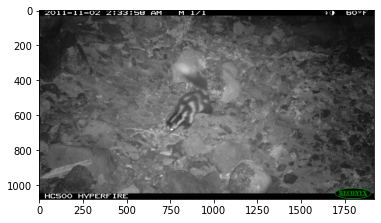

In [140]:
plt.imshow(cv2.imread(myimgpaths[0]))

In [141]:
def getSequenceBGSub(seq_images):
    bgs = []
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    kernel = np.ones((5, 5), np.uint8)
    kernel2 = np.ones((3, 3), np.uint8)
    for im in seq_images:
        backgroundsubbed = fgbg.apply(im)
        backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
        backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
        backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
        backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
        bgs.append(backgroundsubbed)
    # also sub the first image
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    fgbg.apply(seq_images[-1])
    backgroundsubbed = fgbg.apply(seq_images[0])
    backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
    backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
    backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
    backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)    
    bgs[0] = backgroundsubbed
    return bgs

def getBox(src):
    # https://stackoverflow.com/questions/60646384/python-opencv-background-subtraction-and-bounding-box
    src_gray = cv.cvtColor(src,cv.COLOR_BGR2GRAY)

    # adjust brightness
    src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)
    # apply threshold
    threshold = 50
    _, img_thresh = cv.threshold(src_bright, threshold, 255, 0)
    # apply erode
    erosion_size = 7
    erosion_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    img_erosion = cv.erode(img_thresh, element)
    # apply dilate
    dilatation_size = 17
    dilatation_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    img_dilate = cv.dilate(img_erosion, element)

    # apply canny and find contours
    threshold = 50
    canny_output = cv.Canny(img_dilate, threshold, threshold * 2)
    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    xmax = ymax = 1
    xmin = ymin = 99999
    for c in contours:
        for cs in c:
            x, y = cs[0]
            if x > xmax: xmax = x
            if x < xmin: xmin = x
            if y > ymax: ymax = y
            if y < ymin: ymin = y
    return xmin, xmax, ymin, ymax


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [142]:
sequence_path = myimgpaths
seq_images = [cv2.imread(img) for img in sequence_path]

698 1026 280 729


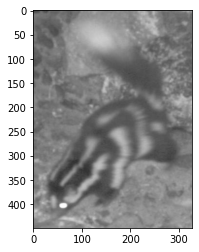

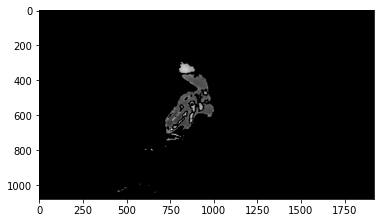

524 1027 281 842


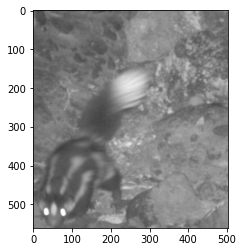

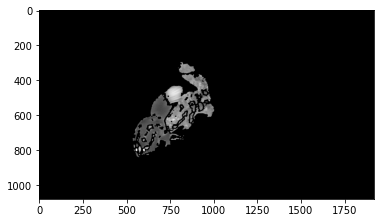

466 773 433 1005


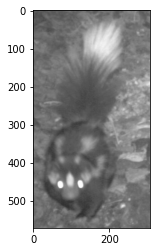

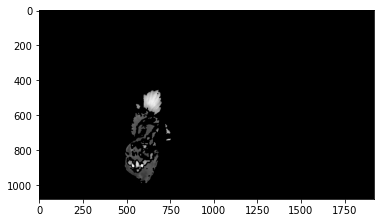

444 728 458 1070


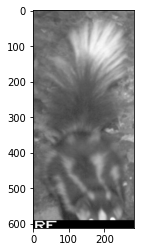

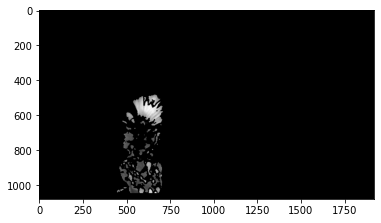

432 755 490 1070


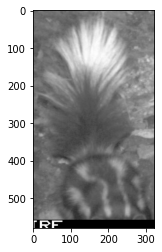

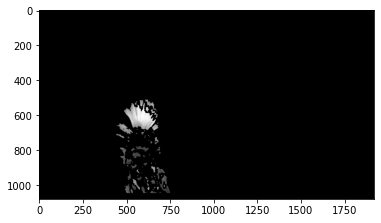

652 951 439 1070


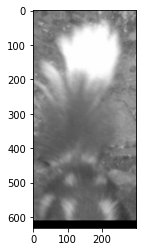

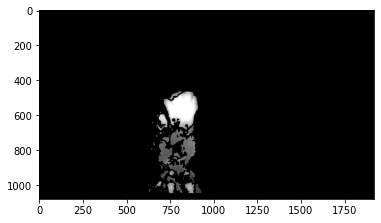

693 1029 597 1070


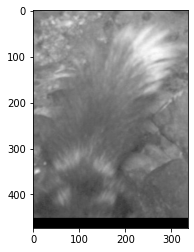

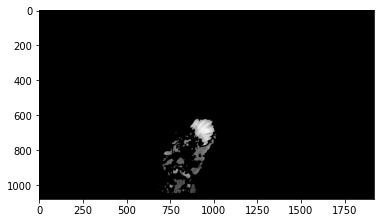

C:\Users\jakob\AppData\Local\Temp\ipykernel_2108\4101933444.py:29: RuntimeWarning: divide by zero encountered in true_divide
  src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)


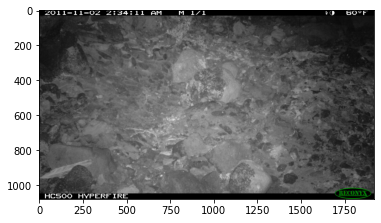

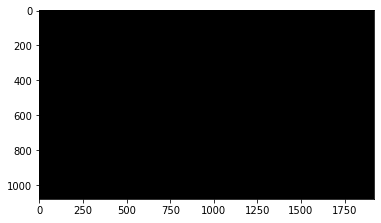

In [143]:
import time
bgs = getSequenceBGSub(seq_images)
imgs = []
for i, bg in enumerate(bgs):
    width, height = bg.shape
    boolbackground = bg != 0
    img = seq_images[i]
    img_booled = img * boolbackground[..., np.newaxis]
    xmin, xmax, ymin, ymax = getBox(img_booled)
    if (xmax-xmin) < 10 or (ymax - ymin) < 10:
        reshaped_img = img
    else:
        xmin, xmax = max(xmin-15, 0), min(xmax+15, width)
        ymin, ymax = max(ymin-15, 0), min(ymax+15, height)
        print(xmin, xmax, ymin, ymax)
        reshaped_img = img[ymin:ymax, xmin:xmax, :]
    imgs.append(reshaped_img)
    plt.figure()
    plt.imshow(reshaped_img)
    plt.show()
    plt.figure()
    plt.imshow(img_booled)
    plt.show()

In [127]:
imgs_boxed = [letterbox(im, 256, auto=False)[0] for im in imgs]

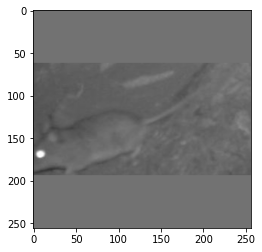

In [129]:
plt.imshow(imgs_boxed[0])

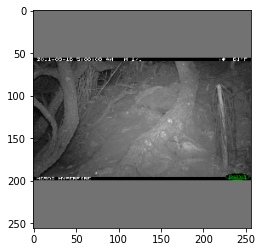

In [131]:
plt.imshow(letterbox(cv2.imread(myimgpaths[0]), 256, auto=False)[0])

In [40]:
cv2.imwrite('c:/temp/letterboxautobox.jpg', imgs_boxed[0])

True

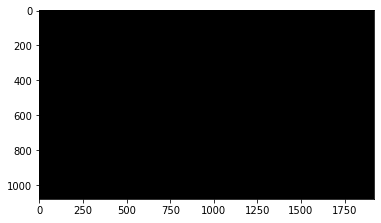

In [34]:

# apply approxPolyDP, hull, boundingRect and calculate areas for each contour
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
areas = [None]*len(contours)
hull_list = []
for i, c in enumerate(contours):
    contours_poly[i] = cv.approxPolyDP(c, 3, True)
    hull_list.append(cv.convexHull(contours[i]))
    boundRect[i] = cv.boundingRect(contours_poly[i])
    areas[i] = cv.contourArea(c)

# set drawing 
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
# draw only the contour with the greatest area
i = areas.index(max(areas))
# color = (0,0,255)
# cv.drawContours(drawing, contours_poly, i, (0,255,0),2)
# cv.drawContours(drawing, hull_list, i, (255,0,0),2)
# cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
#   (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 3)

height, width, _ = src.shape
max_x = max_y = 0
min_x, min_y = width, height

for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    min_x, max_x = min(x, min_x), max(x+w, max_x)
    min_y, max_y = min(y, min_y), max(y+h, max_y)
    if w > 10 and h > 10:
      cv2.rectangle(drawing, (x,y), (x+w,y+h), (255, 0, 0), 2)

# # Alternatively, you can draw contours with area bigger than some value
# for i in range(len(contours[1])):
#     if areas[i] > 1000:
#         color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
#         cv.drawContours(drawing, contours_poly, i, color)
#         cv.drawContours(drawing, hull_list, i, color)
#         cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
#           (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

# im = cv2.blend('blend',cv.add(drawing,src))
plt.imshow(drawing)

In [153]:
imr[1].shape


(1080, 1920, 3)

In [159]:
imheight, imwidth, _ = imr[1].shape
xmass, ymass = ndimage.center_of_mass(bgs[1])
xmass, ymass = xmass//1, ymass//1

xmin, xmax = int(max(0, xmass-320)), int(min(imwidth-1, xmass+320))
ymin, ymax = int(max(0, ymass-320)), int(min(imheight-1, ymass+320))

In [56]:
og = cv2.imread(myimgpaths[1])

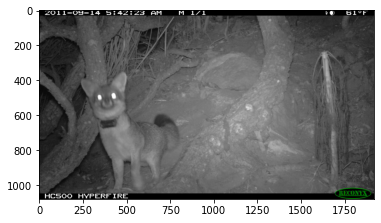

In [59]:
plt.imshow(og)

In [60]:
reshaped_img = og[ymin:ymax, xmin:xmax, :]

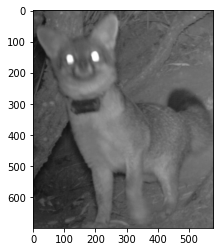

In [61]:
plt.imshow(reshaped_img) 

In [64]:
tmpimr2 = imr[1]

In [72]:
xmass, ymass = ndimage.center_of_mass(bgs[1])
xmass, ymass = xmass//1, ymass//1

(678.0, 534.0)

In [141]:
x,y,w,h = cv2.boundingRect(tmp)
cv2.rectangle(tmpimr,(x,y),(x+w,y+h),(0,255,0),2)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'boundingRect'
> Overload resolution failed:
>  - array data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'array'


In [74]:
threshold = 100
_, img_thresh = cv2.threshold(bgs[1], threshold, 255, 0)

In [71]:
tmp

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [77]:
img_thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [82]:
erosion_size = 7
erosion_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
img_erosion = cv2.erode(img_thresh, element)

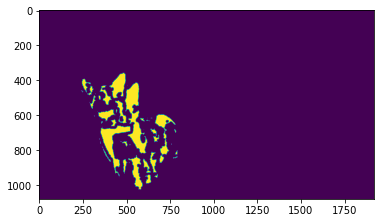

In [83]:
plt.imshow(img_erosion)

In [85]:
dilatation_size = 17
dilatation_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
img_dilate = cv2.dilate(img_erosion, element)

In [88]:
canny_output = cv2.Canny(img_dilate, threshold, threshold * 2)

In [121]:
contours, _ = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [130]:
contours

(array([[[598, 964]],
 
        [[598, 966]],
 
        [[600, 966]],
 
        [[600, 964]]], dtype=int32),
 array([[[593, 941]],
 
        [[593, 942]]], dtype=int32),
 array([[[587, 913]],
 
        [[587, 914]],
 
        [[586, 915]],
 
        [[586, 920]],
 
        [[587, 921]],
 
        [[587, 922]],
 
        [[590, 925]],
 
        [[590, 926]],
 
        [[591, 927]],
 
        [[591, 928]],
 
        [[592, 929]],
 
        [[592, 939]],
 
        [[591, 940]],
 
        [[591, 942]],
 
        [[591, 940]],
 
        [[592, 939]],
 
        [[592, 929]],
 
        [[591, 928]],
 
        [[591, 927]],
 
        [[590, 926]],
 
        [[590, 925]],
 
        [[589, 924]],
 
        [[589, 923]],
 
        [[586, 920]],
 
        [[586, 915]],
 
        [[588, 913]],
 
        [[589, 914]],
 
        [[589, 915]],
 
        [[590, 916]],
 
        [[590, 917]],
 
        [[593, 920]],
 
        [[594, 920]],
 
        [[595, 921]],
 
        [[596, 921]],
 
        [[597,

In [119]:
contours_poly = [None]*len(contours[1])
boundRect = [None]*len(contours[1])
areas = [None]*len(contours[1])
hull_list = []
for i, c in enumerate(contours[1]):
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    hull_list.append(cv2.convexHull(contours[1][i]))
    boundRect[i] = cv2.boundingRect(contours_poly[i])
    areas[i] = cv2.contourArea(c)

In [120]:
areas

[0.0, 0.0]

In [98]:
i = areas.index(max(areas))
color = (0,0,255)
cv2.drawContours(tmpimr2, contours_poly, i, (0,255,0),2)
cv2.drawContours(tmpimr2, hull_list, i, (255,0,0),2)
cv2.rectangle(tmpimr2, (int(boundRect[i][0]), int(boundRect[i][1])), \
  (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [113]:
i

0

TypeError: Invalid shape () for image data

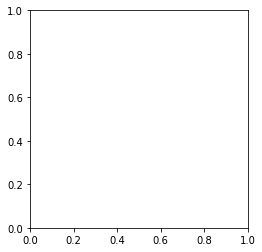

In [112]:
plt.imshow(i)

In [52]:
capture.read()

(False, None)

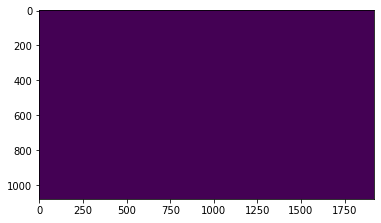

In [35]:
tmp = fgbg.apply(img[1])
plt.imshow(tmp)

In [ ]:
# for f in glob.glob(seq_path + '\*.jpg', recursive=True):
#     os.remove(f)
# for im in myimgpaths: 
#     newfile = shutil.copy2(im, seq_path)

# capture = cv2.VideoCapture(cv2.samples.findFileOrKeep(myimgpaths[0]))
# while True:
#     ret, frame = capture.read()
#     if frame is None:
#         break
#     fgMask = backSub.apply(frame)
#     gMask = backSub.apply(frame)
#     cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
#     cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
#     plt.imshow('frame', frame)
#     plt.imshow('fgmask', fgMask)
#     plt.show()
#     print('asdfasdf')